In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [2]:
X = []
y = []
for year in range(1919, 2020):
    df = pd.read_csv('../core/tensors/games/{}.csv'.format(year), header=None)
    for index in range(0, df.shape[0]):
        game = list(df.iloc[index])
        y_sample = int(game[-1])
        game = game[:-1]
        X.append(game)
        y.append(y_sample)
X = np.array(X)
y = np.array(y)
y = y[..., np.newaxis]

In [3]:
X.shape

(176687, 540)

In [4]:
y.shape

(176687, 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
epochs = 4000
batch_size = 2048
loss_param = 'binary_crossentropy'
optimizer_param = 'adam'
stop_monitor = 'val_loss'
metric = 'accuracy'
stop_patience = 15

In [8]:
model = Sequential()

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001), 
                input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss=loss_param, optimizer=optimizer_param)

In [9]:
early_stop = EarlyStopping(monitor=stop_monitor, patience=stop_patience)

In [11]:
results = model.fit(x=X_train, y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop]
                    )

Train on 141349 samples, validate on 35338 samples
Epoch 1/4000
141349/141349 [==============================] - 2s 16us/sample - loss: 0.7246 - val_loss: 0.7154
Epoch 2/4000
141349/141349 [==============================] - 1s 10us/sample - loss: 0.7119 - val_loss: 0.7068
Epoch 3/4000
141349/141349 [==============================] - 1s 9us/sample - loss: 0.7048 - val_loss: 0.7016
Epoch 4/4000
141349/141349 [==============================] - 1s 9us/sample - loss: 0.7004 - val_loss: 0.6975
Epoch 5/4000
141349/141349 [==============================] - 1s 8us/sample - loss: 0.6967 - val_loss: 0.6958
Epoch 6/4000
141349/141349 [==============================] - 1s 8us/sample - loss: 0.6949 - val_loss: 0.6939
Epoch 7/4000
141349/141349 [==============================] - 1s 8us/sample - loss: 0.6927 - val_loss: 0.6912
Epoch 8/4000
141349/141349 [==============================] - 1s 9us/sample - loss: 0.6909 - val_loss: 0.6900
Epoch 9/4000
141349/141349 [==============================] - 1s 8u

In [12]:
losses = model.history.history
losses['loss'] = np.asarray(losses['loss'])
losses['val_loss'] = np.asarray(losses['val_loss'])
final_number_of_epochs = len(losses['loss'])
min_loss = losses['loss'].min()
mean_loss = losses['loss'].mean()
final_loss = losses['loss'][-1]
min_val_loss = losses['val_loss'].min()
mean_val_loss = losses['val_loss'].mean()
final_val_loss = losses['val_loss'][-1]


def get_model_summary():
    output = []
    model.summary(print_fn=lambda line: output.append(line))
    return str(output).strip('[]')


summary = get_model_summary()

record = {
    'Epochs': final_number_of_epochs,
    'Batch_Size': batch_size,
    'Loss_Func': loss_param,
    'Optimizer': optimizer_param,
    'Early_Stop_Monitor': stop_monitor,
    'Early_Stop_Patience': stop_patience,
    'Min_Loss': min_loss,
    'Mean_Loss': mean_loss,
    'Final_Loss': final_loss,
    'Min_Val_Loss': min_val_loss,
    'Mean_Val_Loss': mean_val_loss,
    'Final_Val_Loss': final_val_loss,
    'Model': summary
}

In [13]:
new_data = pd.DataFrame(record, index=[0])
if os.path.exists('../core/records/games_ann.csv'):
    df_records = pd.read_csv('../core/records/games_ann.csv')
    df_records = df_records.append(new_data)
else:
    df_records = pd.DataFrame(new_data)

df_records.to_csv('../core/records/games_ann.csv',
                  index=False, float_format='%g')

model.save('../core/models/games_ann.h5')

In [14]:
losses = pd.DataFrame(model.history.history)

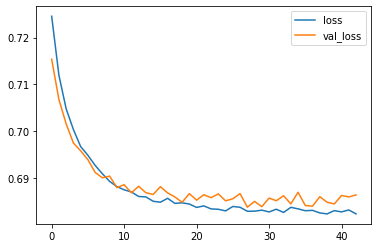

In [15]:
losses.plot()